In [28]:
import json, requests, sqlite3, matplotlib.pyplot as plt

In [29]:
API_TOKEN = ""
NUM_STATIONS = 25
#Connect to database
conn = sqlite3.connect('C:/sqlite/UnitedStations.db')
c = conn.cursor()

In [30]:
#Retrieve list of states
c.execute("SELECT DISTINCT state FROM stations")
states_raw = c.fetchall()
states = []
for state in states_raw:
    states.append(state[0].lower())

In [31]:
#Prompt user for state:
while True:
    st = input("Enter state to be analzyed: ").lower()
    if st in states:
        break
    print("State not found, try again.")

Enter state to be graphed: Kansas


In [32]:
#create table (and clear it if it exists) for selected state
c.execute('''CREATE TABLE IF NOT EXISTS temps_{}
            (station text, year real, maxtemp real, mintemp real, PRIMARY KEY (station, year))'''.format(st.replace(" ", "_")))
c.execute("DELETE FROM temps_{}".format(st.replace(" ", "_")))
conn.commit()

In [ ]:
get_temps(st)
conn.commit()
plot(st)

In [33]:
def get_temps(state):
    count = 0
    station_ids = get_random_stations(state)
   
    #Inserting IDs and years into temps_(state)
    for s in station_ids:
        count += 1
        print("Looking at station {} of {}".format(count, NUM_STATIONS), end = "\r")
        for y in range(1950,2017):
            c.execute("INSERT INTO temps_{}(station, year) VALUES ({},{})".format(state.replace(" ", "_"), repr(s), y))
        #API calls
        temps_request(state, s)
    
    
    #store in table corresponding to the state
    conn.commit()

In [34]:
#returns list of strings of station IDs
def get_random_stations(state):
    c.execute('''SELECT ID FROM stations WHERE state LIKE {} AND mindate < 19500101 AND maxdate > 20171231 
              ORDER BY RANDOM() LIMIT {}'''.format(repr(state), NUM_STATIONS))
    id_tuple = c.fetchall()
    ids = [i[0] for i in id_tuple]
    return ids
    

In [35]:
def temps_request(state, station):
    final_year = 2018
    current_year = 1950

    while current_year < final_year:
        req_max = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GSOY&stationid={}&units=standard&startdate={}-01-01&enddate={}-01-01&limit=1000&datatypeid=TMAX&units=metric"
                               .format(station, str(current_year), str(current_year+10)), headers={"token":API_TOKEN})

        max_t = json.loads(req_max.text)
        if 'results' in max_t:
            #print("In max if")
            max_temps = max_t['results']
            for t in max_temps:
                c.execute("UPDATE temps_{} SET maxtemp = {} WHERE station = {} AND year = {}".format(state.replace(" ", "_"), t['value'], repr(station), int(t['date'][:4])))
             

        req_min = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GSOY&stationid={}&units=standard&startdate={}-01-01&enddate={}-01-01&limit=1000&datatypeid=TMIN&units=metric"
                               .format(station, str(current_year), str(current_year+10)), headers={"token":API_TOKEN})
        min_t = json.loads(req_min.text)
        if 'results' in min_t:
            #print("In min if")
            min_temps = min_t['results']
            for t in min_temps:
                c.execute("UPDATE temps_{} SET mintemp = {} WHERE station = {} AND year = {}".format(state.replace(" ", "_"), t['value'], repr(station), int(t['date'][:4])))

        current_year = current_year + 10

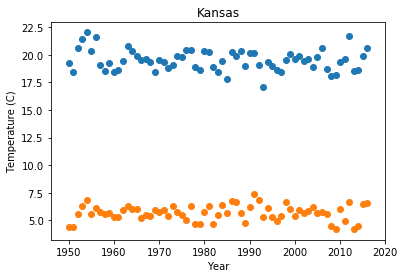

In [36]:
def plot(state):
    years = list(range(1950,2017))
    minimums = []
    maximums = []
    for y in years:
        c.execute("SELECT AVG(mintemp), AVG(maxtemp) FROM temps_{} WHERE year = {}".format(state, y))
        averages = c.fetchall()
        minimums.append(averages[0][0])
        maximums.append(averages[0][1])
    
    plt.scatter(years, maximums)
    plt.scatter(years, minimums)
    plt.xlabel("Year")
    plt.ylabel("Temperature (C)")
    plt.title(state.capitalize())